<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [ ]:
# !apt update && apt install -y openslide-tools
# !pip install openslide-python

In [ ]:
# !rm -r "/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP"
# !git clone https://github.com/frpnz/teaching-MLinAPP.git "/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP"

In [8]:
import os
import sys
import openslide
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = 'true'
import matplotlib.pyplot as plt
import openslide.deepzoom as dz
from sklearn import model_selection
rootdir_wsi = "/space/ponzio/CRC_ROIs_4_classes/"
rootdir_src = "/space/ponzio/teaching-MLinAPP/src/"
sys.path.append(rootdir_src)
from resnet import ResNet
from dataset_from_wsi import DatasetManager
from sklearn import model_selection
# ----------------------
tile_size = 700
tile_new_size = 64
overlap = 1
epochs = 100
learning_rate = 0.0001
batch_size = 128
channels = 3
class_dict = {
    "AC": 0,
    "AD": 1,
    "H": 2
}
checkpoint_filepath = './models_crc/checkpoint_crc_3_cls'                                                                                                                                                             
# ----------------------
input_shape = (tile_new_size, tile_new_size, channels)
num_classes = len(class_dict.keys())
wsi_file_paths = glob(os.path.join(rootdir_wsi, '*.svs'))
df = pd.DataFrame([os.path.basename(slide).split('.')[0].split('_') for slide in wsi_file_paths], columns=["Patient",
                                                                                                           "Type",
                                                                                                           "Sub-type",
                                                                                                           "Dysplasia",
                                                                                                           "#-Annotation"])
df['Path'] = wsi_file_paths
splitter = model_selection.GroupShuffleSplit(test_size=.4, n_splits=1, random_state=7)
split = splitter.split(df, groups=df['Patient'])
train_inds, test_inds = next(split)

train = df.iloc[train_inds]
test = df.iloc[test_inds]
wsi_file_paths_train = train['Path']
wsi_labels_categorical_train = train['Type']
wsi_labels_numerical_train = [class_dict[label] for label in wsi_labels_categorical_train]
wsi_file_paths_test = test['Path']
wsi_labels_categorical_test = test['Type']
wsi_labels_numerical_test = [class_dict[label] for label in wsi_labels_categorical_test]

In [9]:
print("Training")
dataset_manager_train = DatasetManager(wsi_file_paths_train,
                                       wsi_labels_numerical_train,
                                       tile_size=tile_size,
                                       tile_new_size=tile_new_size,
                                       channels=channels,
                                       batch_size=batch_size)
dataset_train = dataset_manager_train.make_dataset()
print("Test")
dataset_manager_test = DatasetManager(wsi_file_paths_test,
                                      wsi_labels_numerical_test,
                                      tile_size=tile_size,
                                      tile_new_size=tile_new_size,
                                      channels=channels,
                                      batch_size=batch_size)
dataset_test = dataset_manager_test.make_dataset(shuffle=False)

Training
***************************
Found in total:
 10232 tiles
 belonging to 90 slides
***************************
Test
**************************
Found in total:
 7264 tiles
 belonging to 57 slides
**************************


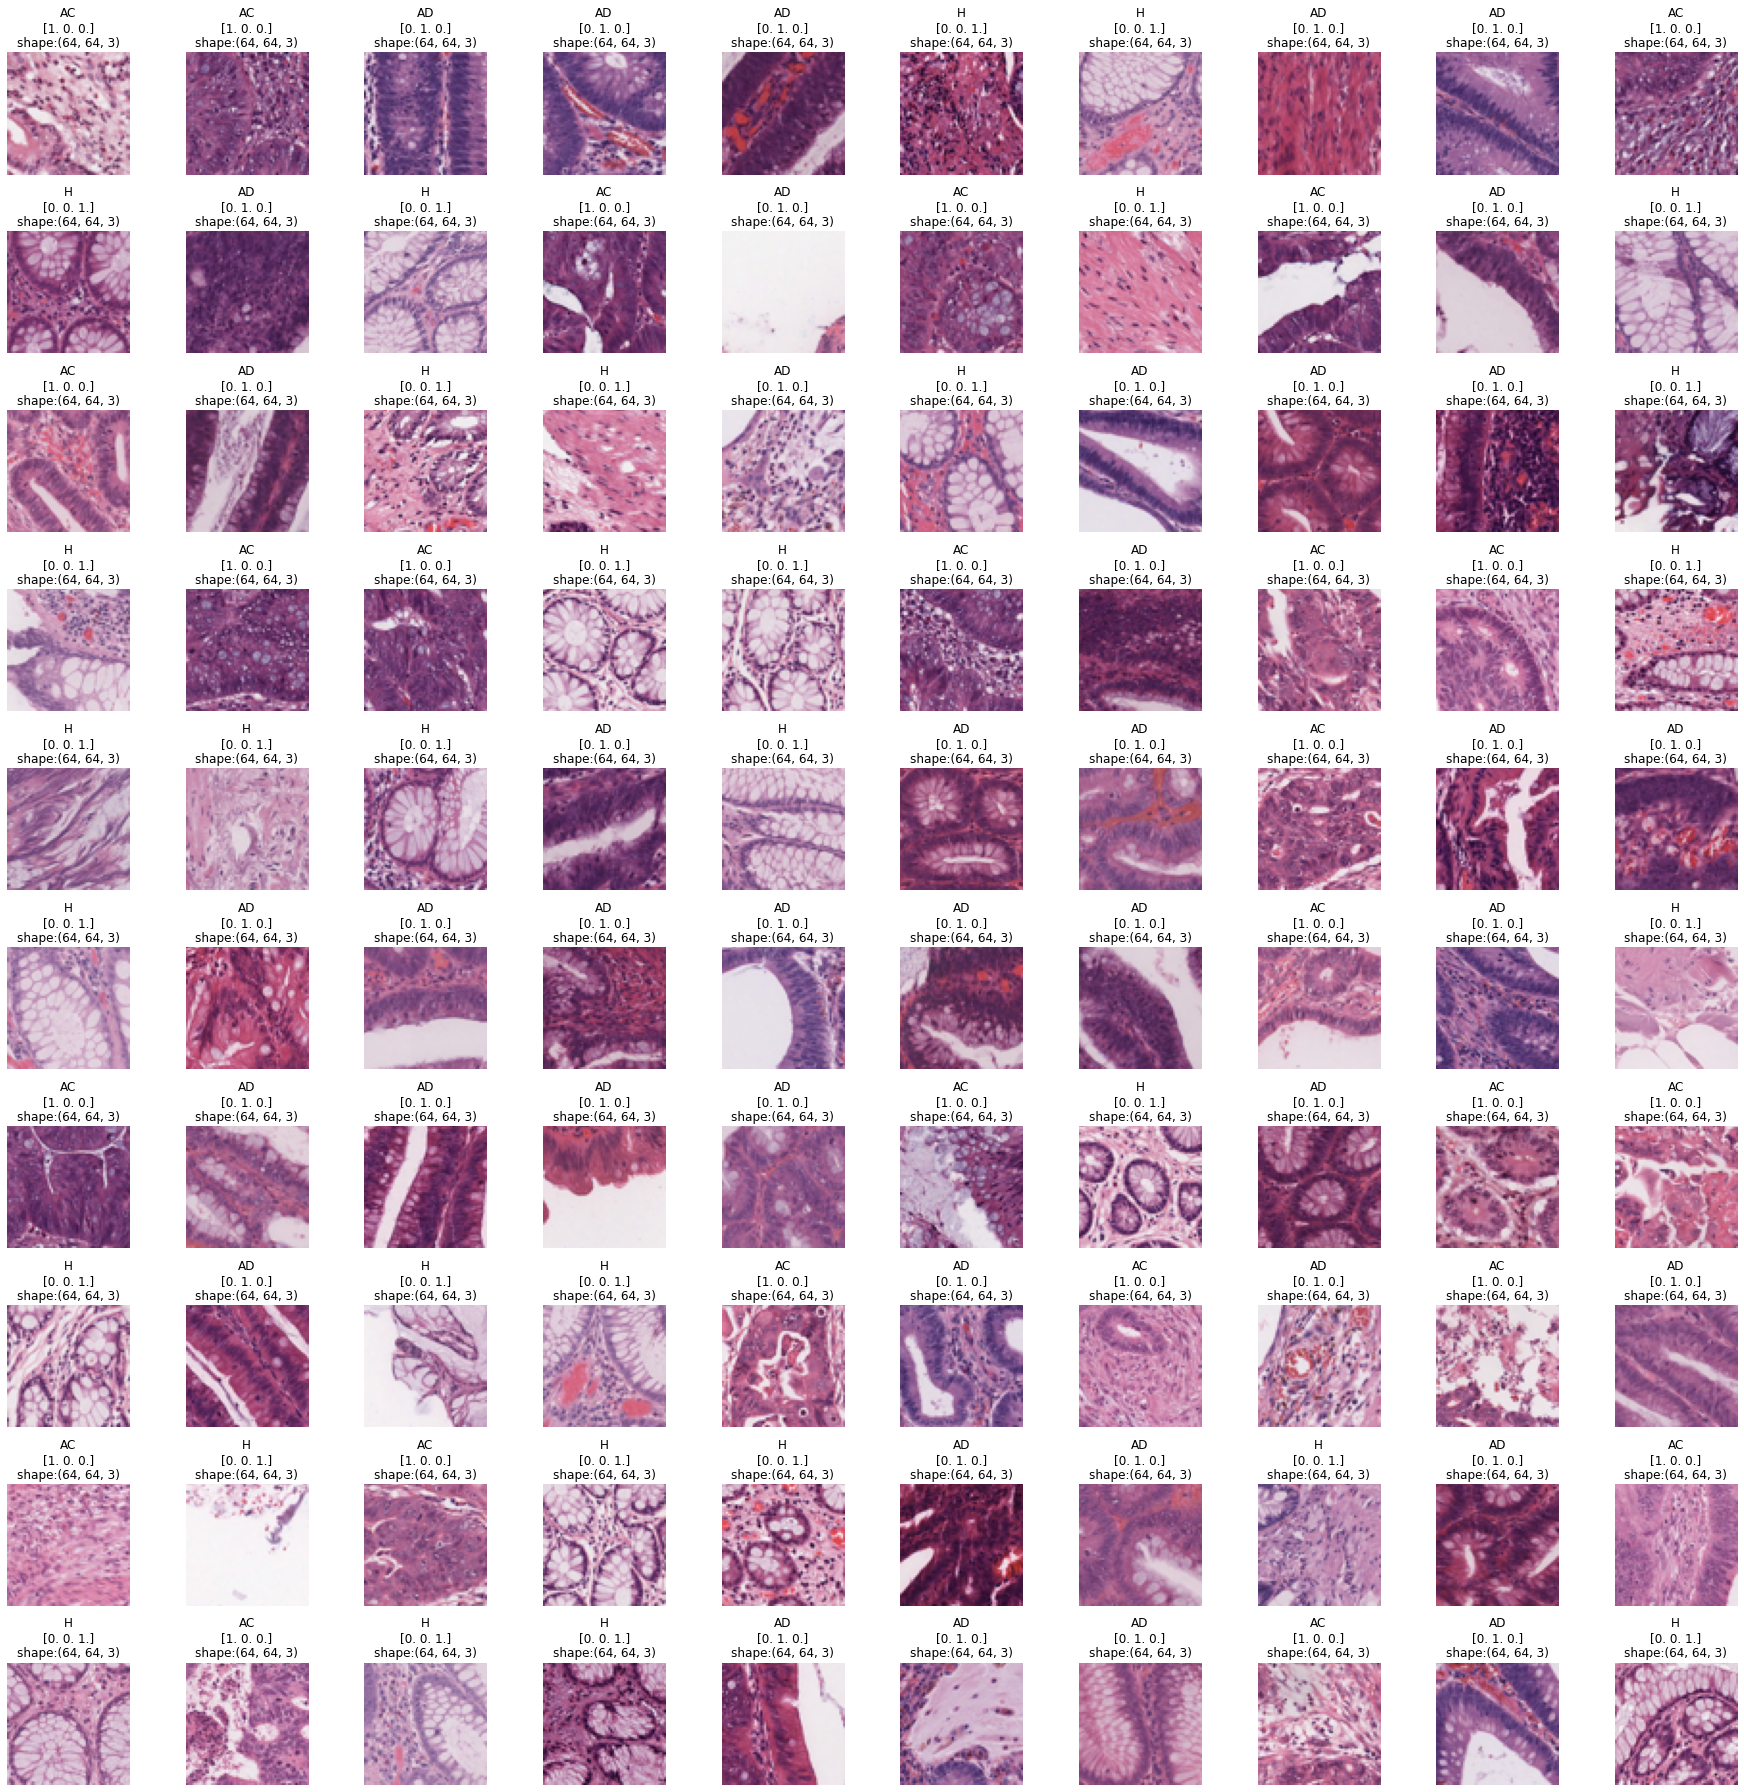

In [10]:
inv_class_dict = {v: k for k, v in class_dict.items()}
for batch_x, batch_y in dataset_train.take(1):
    fig, ax = plt.subplots(10, 10, figsize=(25, 25))
    ax = ax.ravel()
    j = 0
    for image, label in zip(batch_x[:100], batch_y[:100]):
        label = label.numpy()
        img = image.numpy()
        input_shape = img.shape
        ax[j].imshow(img)
        ax[j].axis('off')
        ax[j].set_title("{}\n{}\nshape:{}".format(inv_class_dict[int(np.argmax(label))], label, image.shape))
        j += 1
fig.tight_layout()
fig.savefig("train_images.pdf")

In [ ]:
inv_class_dict = {v: k for k, v in class_dict.items()}
for batch_x, batch_y in dataset_test.take(1):
    fig, ax = plt.subplots(10, 10, figsize=(25, 25))
    ax = ax.ravel()
    j = 0
    for image, label in zip(batch_x[:100], batch_y[:100]):
        label = label.numpy()
        img = image.numpy()
        input_shape = img.shape
        ax[j].imshow(img)
        ax[j].axis('off')
        ax[j].set_title("Class: {} - {}\nshape:{}".format(inv_class_dict[int(np.argmax(label))], label, image.shape))
        j += 1
fig.tight_layout()
fig.savefig("test_images.pdf")

In [ ]:
# data_dir = "./crc_images/train"
# train_ds = tf.keras.utils.image_dataset_from_directory(
#     data_dir,
#     validation_split=0.2,
#     subset="training",
#     label_mode="categorical",
#     seed=123,
#     image_size=(input_shape[0], input_shape[1]),
#     batch_size=64)

# val_ds = tf.keras.utils.image_dataset_from_directory(
#     data_dir,
#     validation_split=0.2,
#     subset="validation",
#     label_mode="categorical",
#     seed=123,
#     image_size=(input_shape[0], input_shape[1]),
#     batch_size=64)

# data_dir = "./crc_images/test"
# test_ds = tf.keras.utils.image_dataset_from_directory(
#     data_dir,
#     label_mode="categorical",
#     seed=123,
#     image_size=(input_shape[0], input_shape[1]),
#     batch_size=64)

In [ ]:
augmentation_block = [
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomZoom(
        height_factor=(-0.05, -0.15),
        width_factor=(-0.05, -0.15)),
    tf.keras.layers.RandomRotation(0.3),
]
inputs = tf.keras.Input(input_shape)
x =  tf.keras.applications.resnet50.preprocess_input(inputs)
x = tf.keras.layers.Resizing(64, 64)(x)
for layer in augmentation_block:
    x = layer(x, training=False)
base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet")
for j, layer in enumerate(base_model.layers[:100]):
    layer.trainable = False
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
model = tf.keras.models.Model(inputs=inputs, outputs=x)
# model = ResNet((input_shape[0], input_shape[1]), 
#                num_classes=num_classes, 
#                augment=True)

In [ ]:
model.summary()

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(                                                                                                                                          
    filepath=checkpoint_filepath,                                                                                                                                                                        
    save_weights_only=True,                                                                                                                                                                              
    monitor='accuracy',                                                                                                                                                                              
    mode='max',                                                                                                                                                                                          
    save_best_only=True)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='accuracy',
    factor=0.1,
    patience=7,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    min_delta=0.001,
    patience=10,
    verbose=0,
    mode="auto",
    restore_best_weights=True,
)

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
loss = tf.keras.losses.categorical_crossentropy
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

In [ ]:
model.fit(dataset_train, epochs=epochs, callbacks=[checkpoint_callback, lr_callback, early_stop_callback])

In [ ]:
results = model.evaluate(dataset_test)

In [ ]:
print("Accuracy: {}".format(results[1]))